<a href="https://colab.research.google.com/github/z101ctrl/uba-alc/blob/main/TP1_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP Grupal ALC-métodos


## TODO

### TP 1
- [x] Arreglar el K
- [ ] 1: consultar y corregir.
- [ ] 2: corregir
- [ ] 3: hacer un subplot con todos los mapas con un subplot.
- [ ] 3c: corregir lo siguiente

<font color='orange'>Nico: Hay que identificar el top 3 para cada m (idem por alfa). Dicho de otra manera, queremos plotear la evolución del ranking de todo museo que alguna vez fue relevante al variar m (estuvo en el top3). Esto nos permite hacer una análisis un poco más profundo luego. </font>


- [ ] 3 (análisis)
  - [ ] Buscar ejemplos que respalden el análisis, mostrarlos.
  - [ ] Hacer mapa con flechas para mostrar cómo se transfiere la relevancia.
  - [ ] Entender qué significa que se transfiera la relevancia.
  - [ ] Contestar la pregunta de estabilidad. Dar noción de estabilidad y poner ejemplos.
- [ ] 6: desarrollo en $\LaTeX$ de lo que estamos estimando, descripción.

In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy

np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [33]:
try:
    import google.colab
    import requests

    url = "https://raw.githubusercontent.com/z101ctrl/uba-alc/refs/heads/main/template_funciones.py"
    code = requests.get(url).text
    exec(code)

except ImportError:
    from google.colab import drive
    import sys
    drive.mount('/content/drive/', force_remount=True)
    sys.path.append('/content/drive/MyDrive/ALC/')
    %load_ext autoreload

    %autoreload 2
    from template_funciones import *
import requests



# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [34]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

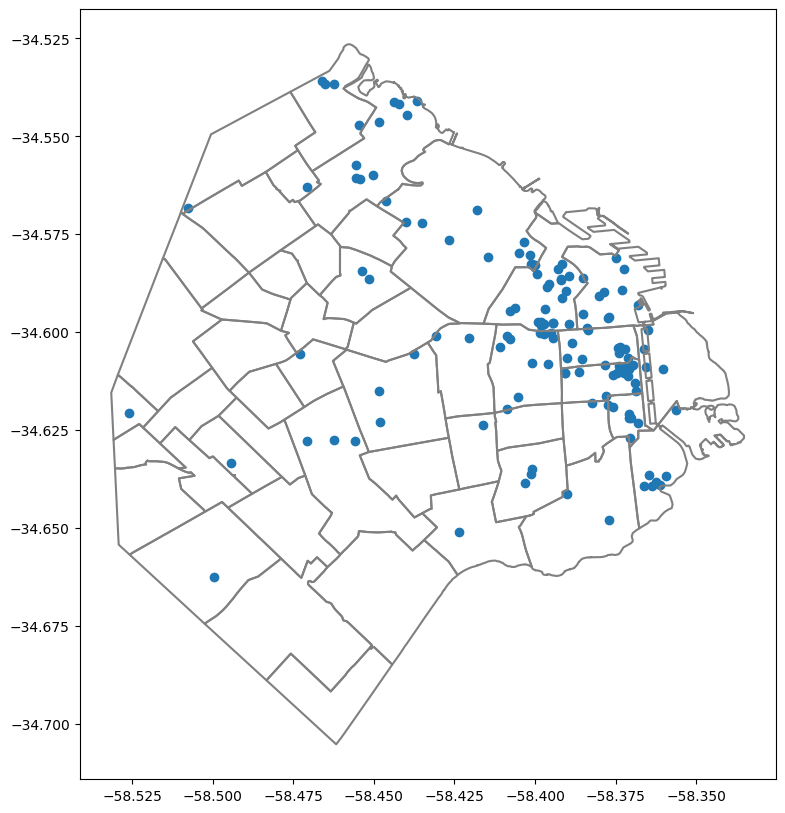

In [35]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [36]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [37]:
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [9]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

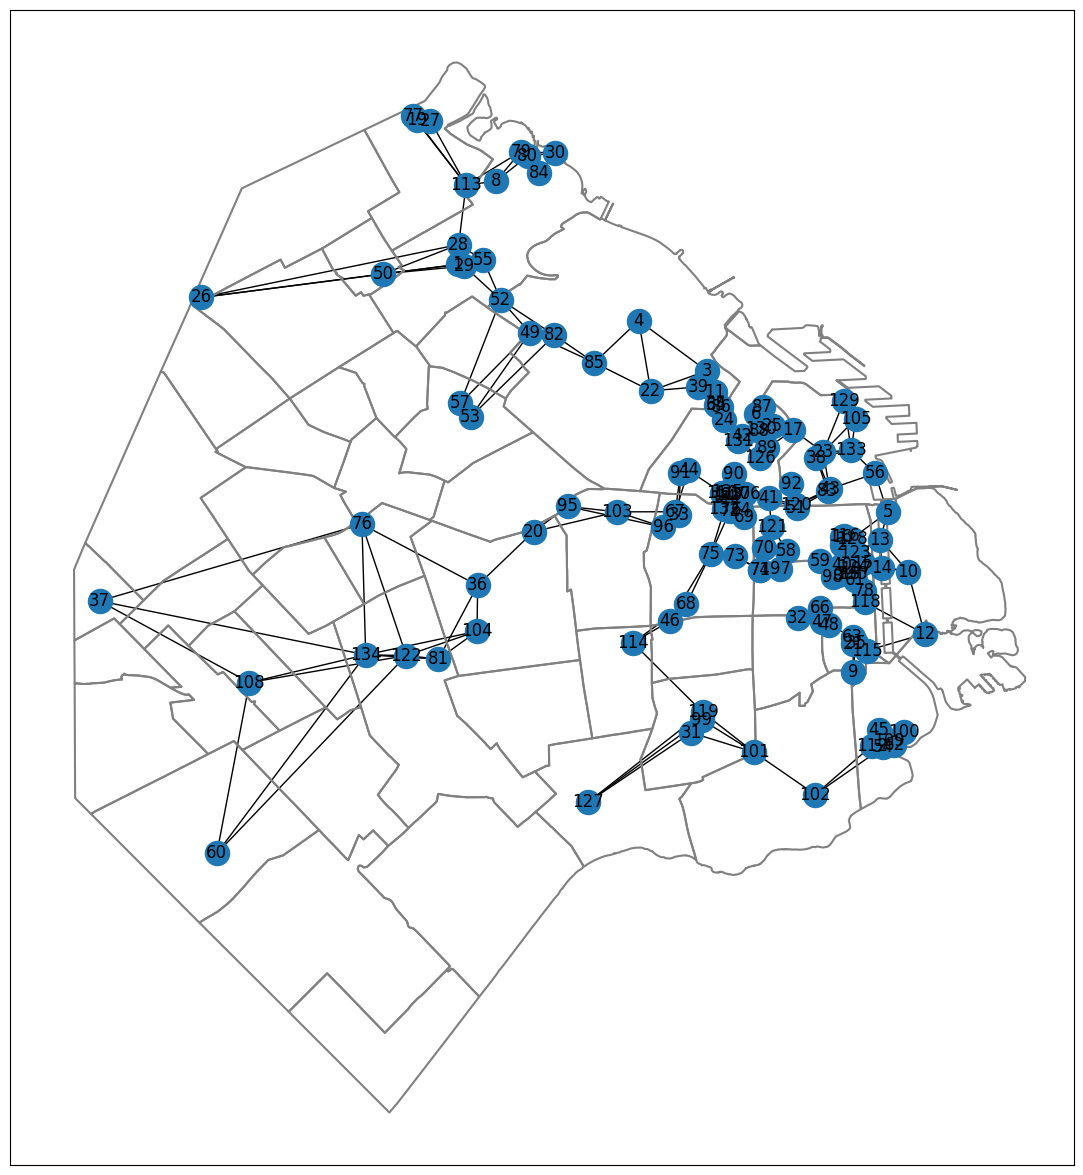

In [10]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

In [11]:
def tres_museos_mas_centrales(C):
  """
  Dada la matriz C, devuelve los indices de los 3 museos mas centrales.

  Input:
    C: matriz de NxN

  Output:
    índices de los 3 museos mas centrales
  """
  # lista con cant. de elementos por columna.
  col_count = []
  for i in range(C.shape[1]):
      count = 0
      for elem in C[:,i]:
          count += 1 if elem != 0 else 0
      col_count.append(count)
  return np.argsort(col_count)[-3:]

## Punto 1:

Queremos ver que $\ M\vec{p} = \vec{b} \ \ $
con $\ \ M = \frac{N}{\alpha} \Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \ \ $
y $\ \ \vec{b} = \vec{1}$

\

$$
\text{Reemplazando:} \\
\\
M\vec{p} = \biggr[\frac{N}{\alpha} \Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \biggr] \vec{p} = \vec{1} = \vec{b} \\
\biggr[ \frac{N}{\alpha} \Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \biggr] \vec{p} = \vec{1} \\
\biggr[ \frac{N}{\alpha}I - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C \biggr] \vec{p} = \vec{1} \\
\frac{N}{\alpha}I\vec{p} - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C\vec{p} = \vec{1} \\
$$
\
$$
\text{Además, sabemos la ecuación de } \vec{p}: \\
\vec{p} = (1-\alpha)C\vec{p} + \frac{\alpha}{N}\vec{1}
$$
\
$$
\text{Reemplazando:} \\
\\
\frac{N}{\alpha}I \biggr[ (1-\alpha)C\vec{p} + \frac{\alpha}{N}\vec{1} \biggr] - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C\vec{p} = \vec{1} \\
\frac{NI}{\alpha} (1-\alpha)C\vec{p} + \frac{N\alpha}{N\alpha}\vec{1}  - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C\vec{p} = \vec{1} \\
\frac{N}{\alpha} I (1-\alpha)C\vec{p} + \vec{1}  - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C\vec{p} = \vec{1} \\
$$
\
$$
\text{Como } IA = A: \\
\\
\frac{N}{\alpha} (1-\alpha)C\vec{p} + \vec{1}  - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C\vec{p} = \vec{1} \\
$$
\
$$
\text{Cancelando nos queda finalmente:} \\
\vec{1} = \vec{1} \\
\text{Por ende probamos que es solución} \\
$$

## Punto 2:


$$
M\vec{p} = \biggr[\frac{N}{\alpha} \Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \biggr] \vec{p} = \vec{b} \quad \text{tiene solucion unica}
\quad \Longleftrightarrow \quad
Nu(M)=\vec{0}
$$
\
$$
\text{Asumo que} \quad ∃ \ \vec{p}\neq\vec{0} \ / \ M\vec{p}=\vec{0} \\
\biggr[\frac{N}{\alpha} \Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \biggr] \vec{p} = \vec{0} \\
\Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \vec{p} = \vec{0} \\
I\vec{p}-\bigl(1-\alpha\bigl)C\ \vec{p} = \vec{0} \\
\vec{p} - \bigl(1-\alpha\bigl) C\vec{p} = \vec{0} \\
\vec{p} = \bigl(1-\alpha\bigl) C\vec{p} \\
\Vert \vec{p} \Vert_1 = \bigl(1-\alpha\bigl) \Vert C\vec{p} \Vert_1 \\
$$
\
$$
\text{Con} \quad \Vert C\vec{p} \Vert \le \Vert C \Vert \Vert \vec{p} \Vert \\
\Vert \vec{p} \Vert_1 \le \bigl(1-\alpha\bigl) \Vert C \Vert_1 \Vert \vec{p} \Vert_1 \\
$$
\
$$
\text{Asumo} \quad \Vert \vec{p} \Vert_1 \neq 0 \\
1 \le \bigl(1-\alpha\bigl) \Vert C \Vert_1 \\
$$
\
$$
\text{Donde} \quad \Vert A \Vert_1 = \max_{1 \le j \le n} \sum_{i=1}^{n} \vert a_{ij} \vert \\
\text{Sin embargo se que} \quad \forall k \in [1,n] \quad \text{vale} \ \ \sum_{i=0}^{n} C_{ki} = 1 \\
\therefore \quad \max_{1 \le j \le n} \sum_{i=1}^{n} C_{ij} = 1 \\
\text{Como} \quad \forall i,j \quad C_{ij} > 0 \\
\max_{1 \le j \le n} \sum_{i=1}^{n} |C_{ij}| = 1 \\
\Vert C \Vert_1 = 1 \\
$$
\
$$
\text{Entonces} \quad 1 \le (1-\alpha) \quad \text{ABS!} \quad \text{ya que} \ \ \alpha \in (0,1) \\
\therefore \quad \nexists \ \ \vec{p} \neq \vec{0} \quad / \quad Nu(M) \neq \vec{0} \\
\text{Es decir que esta condición se cumple por construcción de la matriz} \ M
$$

## Punto 3:

In [12]:
# inciso a
m = 3
alfa = 1/5

# calculo
A = construye_adyacencia(D, m)
C = calcula_matriz_C(A)
p_a = calcula_pagerank(A, alfa)


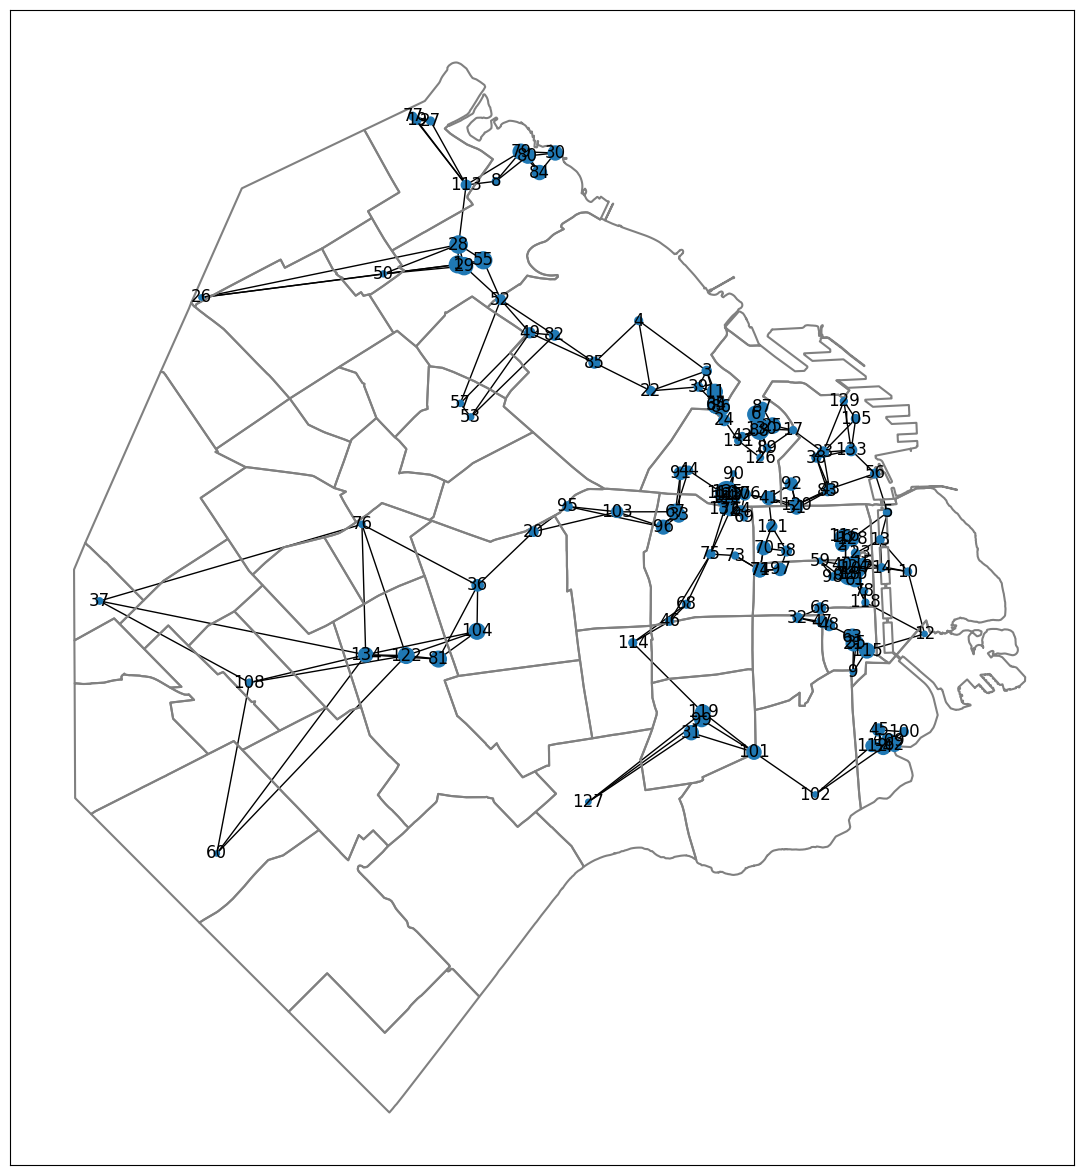

In [13]:
# Visualizamos la red asignando un tamaño del nodo proporcional al page rank que le toca.
G = nx.from_numpy_array(C)
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

fig, ax = plt.subplots(figsize=(15, 15))
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax)
# escalamos para que se vean bien los puntos, son proporcionales a valores de p
nx.draw_networkx(G,G_layout,ax=ax, node_size = p_a * 10e3)


#### Inciso b

In [14]:
m_list = [1, 3 , 5, 10]
alfa = 1/5


p_b_list = []
mas_centrales_b = []

for m in m_list:
  A = construye_adyacencia(D, m)
  p_b_list.append(calcula_pagerank(A, alfa))

  if mas_centrales_b == []:
    for museo in tres_museos_mas_centrales(C):
      mas_centrales_b.append(museo)


Text(0, 0.5, 'Puntaje')

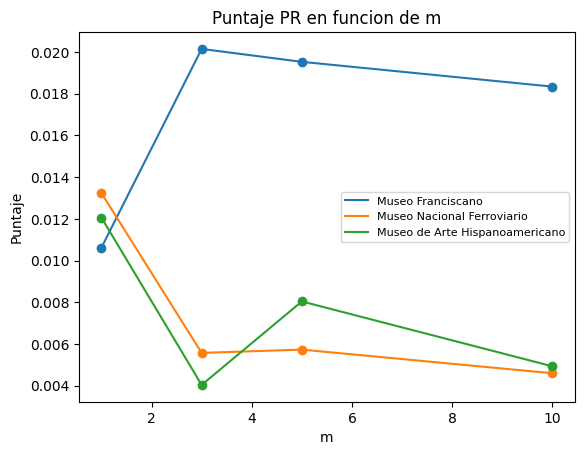

In [15]:
"""
Identificamos 3 museos mas centrales por C y graficamos puntaje en funcion de
parámetro a variar.
"""

museos_mas_centrales = list(museos["name"].loc[mas_centrales_b])

p_individuales = []
for idx in mas_centrales_b:
  p = []
  for elem in p_b_list:
    p.append(elem[idx])
  p_individuales.append(p)

for i, p in enumerate(p_individuales):
  plt.scatter(m_list, p)
  l, = plt.plot(m_list, p)
  l.set_label(museos_mas_centrales[i],)
  plt.legend(fontsize=8)
plt.title("Puntaje PR en funcion de m")
plt.xlabel("m")
plt.ylabel("Puntaje")


Construimos mapa donde vamos cambiando el tamaño de los puntos en función del parámetro a cambiar.

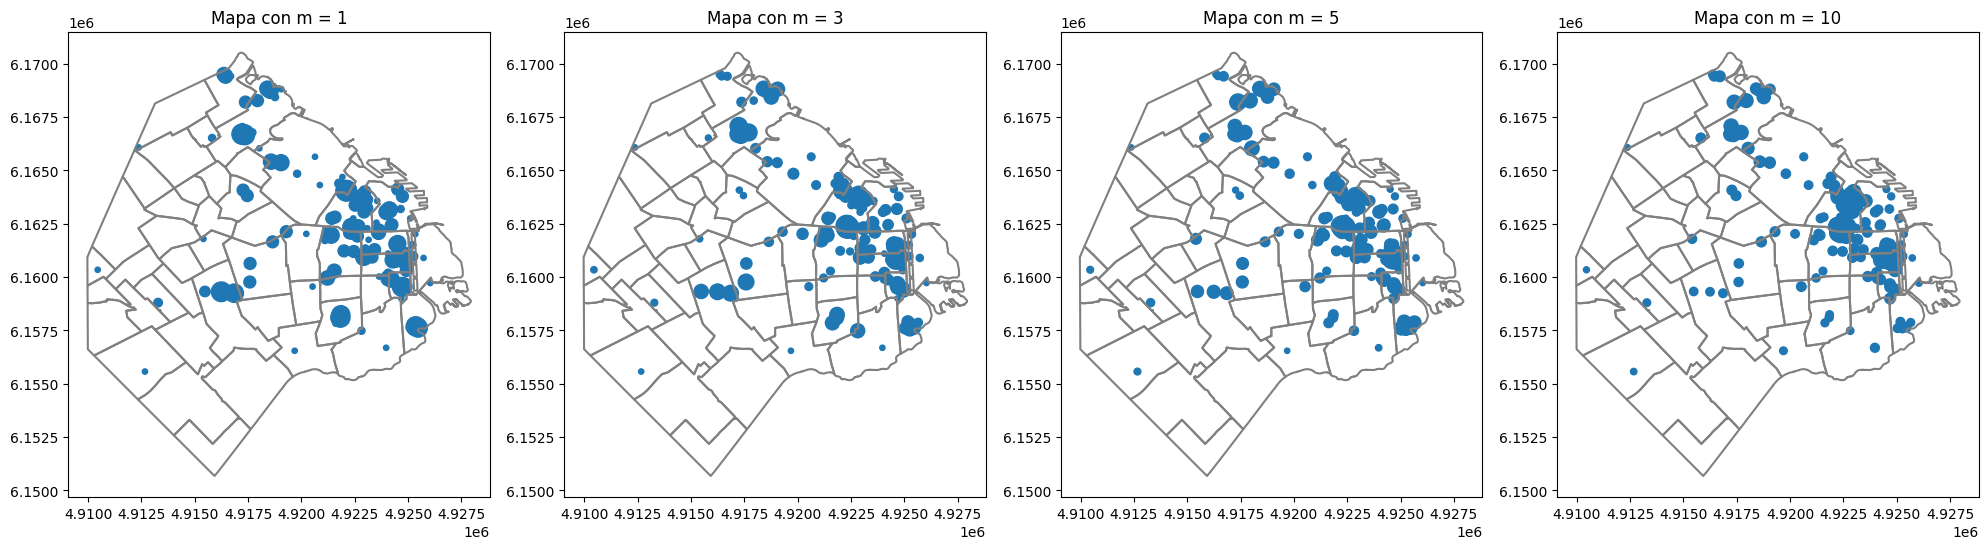

In [16]:
# obtenemos coordenadas
museos_proj = museos.to_crs("EPSG:22184")
G_x = museos_proj.get_coordinates()['x']
G_y = museos_proj.get_coordinates()['y']
barrios_proj = barrios.to_crs("EPSG:22184")

n = len(p_b_list)

fig, axes = plt.subplots(1, n, figsize=(5 * n, 15))  # fila única, ancho proporcional, altura fija

if n == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    barrios_proj.boundary.plot(color='gray', ax=ax)
    ax.scatter(G_x, G_y, s=p_b_list[i] * 1e4)
    ax.set_title(f"Mapa con m = {m_list[i]}")

plt.tight_layout()
plt.show()

#### Análisis

Podemos observar que al aumentar $m$, cambian las posiciones del ranking con respecto al valor inicial, por lo que no se observa estabilidad.

A medida que aumentamos el $m$, se observa que el puntaje de los museos que se encuentran en zonas más densas aumenta rápidamente. Sin embargo, cuando el $m$ excede la cantidad de museos que se encuentran en esa zona de mayor densidad, el puntaje se empieza a distribuir de forma más homogénea.

Notamos que hay museos que comienzan siendo relevantes, y luego no lo son. Esto se puede observar, por ejemplo, con el puntaje del Museo Nacional Ferroviario. Que con un valor pequeño de $m$, su puntaje es mayor, pero a medida que $m$ aumenta, su puntaje disminuye.


### Inciso c

In [17]:
m = 5
alfa_list = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
alfa_list_str = ["6/7", "4/5", "2/3", "1/2", "1/3", "1/5", "1/7"]

p_c_list = []
mas_centrales_c = []

for alfa in alfa_list:
  A = construye_adyacencia(D, m)
  p_c_list.append(calcula_pagerank(A, alfa))
  for museo in tres_museos_mas_centrales(C):
    mas_centrales_c.append(museo)

# sacamos repetidos
mas_centrales_c = list(set(mas_centrales_c))

Text(0, 0.5, 'Puntaje')

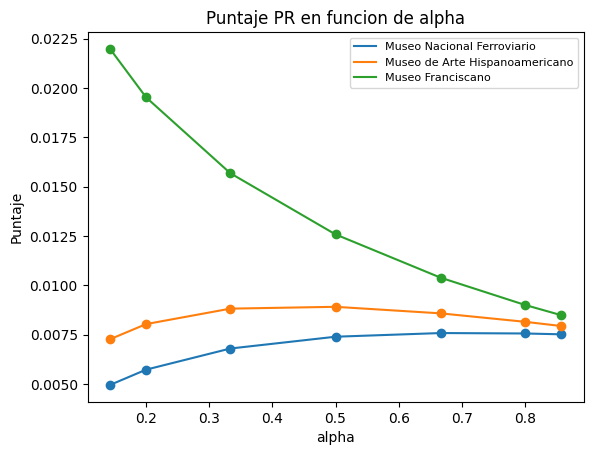

In [18]:
"""
Identificamos 3 museos mas centrales por C y graficamos puntaje en funcion de
parámetro a variar.
"""

museos_mas_centrales = list(museos["name"].loc[mas_centrales_c])

p_individuales = []
for idx in mas_centrales_c:
  p = []
  for elem in p_c_list:
    p.append(elem[idx])
  p_individuales.append(p)

for i, p in enumerate(p_individuales):
  plt.scatter(alfa_list, p)
  l, = plt.plot(alfa_list, p)
  l.set_label(museos_mas_centrales[i],)
  plt.legend(fontsize=8)

plt.title("Puntaje PR en funcion de alpha")
plt.xlabel("alpha")
plt.ylabel("Puntaje")

Construimos mapa donde vamos cambiando el tamaño de los puntos en función del parámetro a cambiar.

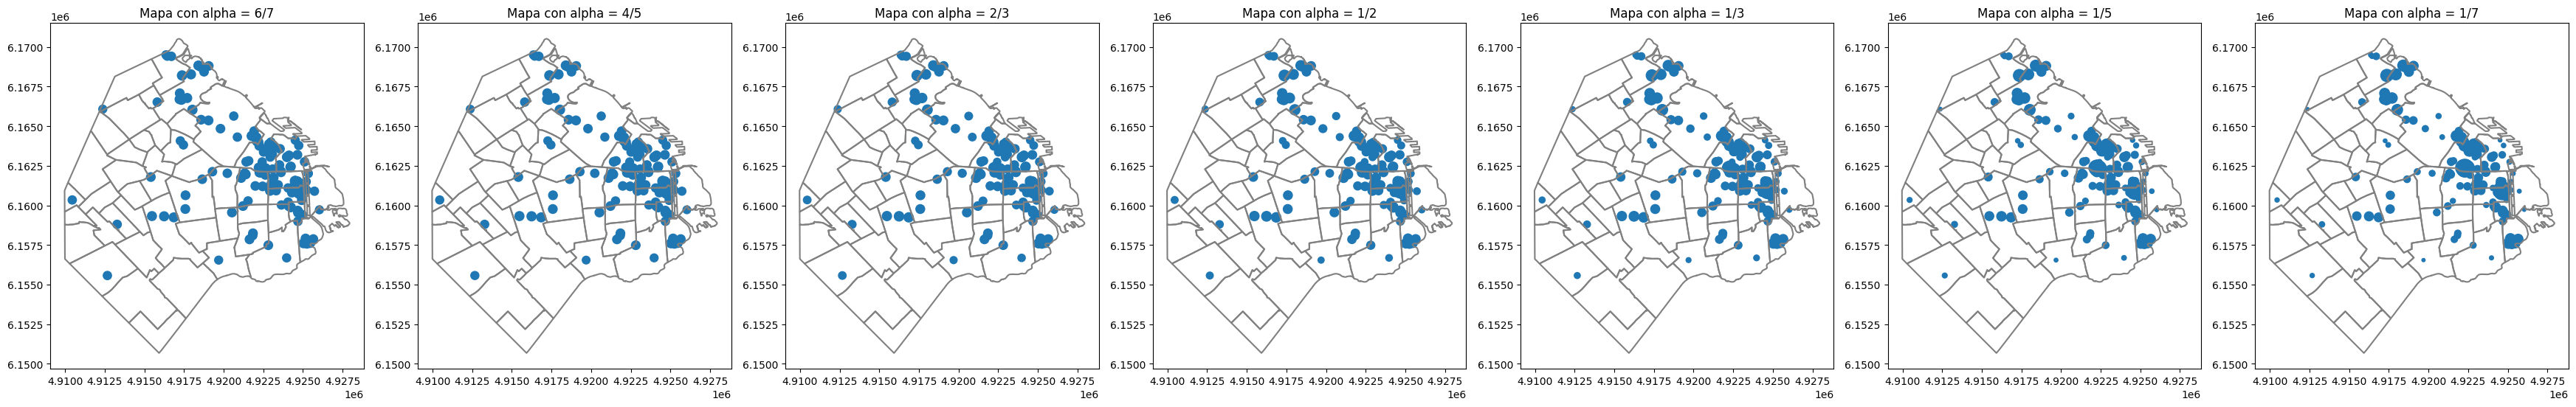

In [19]:

# Proyectamos una sola vez
museos_proj = museos.to_crs("EPSG:22184")
G_x = museos_proj.get_coordinates()['x']
G_y = museos_proj.get_coordinates()['y']
barrios_proj = barrios.to_crs("EPSG:22184")

# Parámetros
n = len(p_c_list)

# Subplots en una sola fila
fig, axes = plt.subplots(1, n, figsize=(5 * n, 6))  # ancho proporcional a la cantidad de plots

# Asegurarse que axes es iterable
if n == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    barrios_proj.boundary.plot(color='gray', ax=ax)
    ax.scatter(G_x, G_y, s=p_c_list[i] * 1e4)
    ax.set_title(f"Mapa con alpha = {alfa_list_str[i]}")

plt.tight_layout()
plt.show()


#### Análisis

A medida que  $\alpha$ se acerca a 1, los puntajes de los museos parecen converger a un mismo punto con la particularidad de que las posiciones en el ranking se mantienen relativamente estables.

Esto sucede debido a que a medida que alpha se acerca a 1, la conexión entre museos pierde relevancia y la gana el factor aleatorio. Esto implica que mientras menor sea el valor de alpha más relevantes serán los museos con mayor cantidad de conexiones.

## Punto 4:


Sea $w$ la cant. de visitantes totales de los museos.

En particular llamaremos $w_i$ a la cant. de visitantes después de $i$-recorridos. Análogamente llamaremos $v_j$ a la distribución de visitantes en el $j$-ésimo recorrido.

$$
\vec{w}_r = \vec{v}_0 + \vec{v}_1 + \vec{v}_2 + \dots + \vec{v}_{r-1} \\
\text{donde} \quad \vec{v}_r = C^r \vec{v}_0 \\
\vec{w}_r = \vec{v}_0 + C^1 \vec{v}_0 + C^2 \vec{v}_0 + \dots + C^{r-1} \vec{v}_0 \\
\vec{w}_r = \sum_{k=0}^{r-1} C^k \vec{v}_0 \\
\quad \text{Llamamos a } \vec{v}_0 = \vec{v} \text{  y  } \vec{w}_r = \vec{w} \\
{Entonces} \quad \vec{w} = \sum_{k=0}^{r-1} C^k \vec{v} \quad \text{y sabemos que} \quad \sum_{k=0}^{r-1} C^k = B  \\
\vec{w} = B \: \vec{v} \\
\text{Asumimos que B tiene inversa. Finalmente:} \\
\vec{v} = B^{-1} \vec{w}
$$

## Punto 5:

In [20]:
# cargamos v del archivo visitas.
import urllib.request

data = urllib.request.urlopen('https://raw.githubusercontent.com/z101ctrl/alc-metodos/refs/heads/main/visitas.txt')

visitas = []
for line in data:
  visitas.append(float(line.decode().strip()))

visitas = np.array(visitas)

In [21]:
r = 3
C = calcula_matriz_C_continua(D)
B = calcula_B(C, r)
B_inv = inv(B)
v = B_inv @ visitas

cantidad_visitantes_iniciales = sum([abs(i) for i in v])
print("La norma 1 de v es:", cantidad_visitantes_iniciales)

La norma 1 de v es: 136604.99999999994


## Punto 6:

In [22]:
condicion_1 = numero_de_condicion_1(B)
cota_error = condicion_1 * 0.05
print("La cota para el error es de", cota_error)
print("El número de condición de B es", condicion_1)

La cota para el error es de 0.25258855883325027
El número de condición de B es 5.051771176665005


#Parte 2

In [23]:
#from template_funciones_2 import *
# TODO: hay que setear esta seed y aclarar por qué se usa.
np.random.seed(1514)

# tomamos A_ejemplo para chequear que las funciones esten bien
A_ejemplo = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
])



#### 3A

In [24]:
# TODO: dejar o bien esta o bien la otra, ya que esta está en la 1era parte
# del TP
def calcula_K(A):
   n, m = A.shape
   K = np.eye(n)
   for i in range(n):
     K[i,i] = sum(A[i, :])
   return K

def calcula_L(A):
  """
  Dada una matriz A calcula la matriz L = K - A.

  Parámetros
  ----------
    * A: matriz A simétrica.

  Devuelve
  ----------
    * L: matriz L.
  """
  K = calcula_K(A)
  L = K - A
  return L

def calcula_P(A):
    """
    Dada una matriz A calcula la matriz P, siendo P:

    P_ij = (K_ii * K_jj) / 2E

    Parámetros
    ----------
      * A: matriz A simétrica.

    Devuelve
    ----------
      * P: matriz P.
    """
    n, m = A.shape
    K = calcula_K(A)
    dos_E = np.sum(A)
    P = np.ones((n, m))
    for i in range(n):
      for j in range(m):
         P[i, j] = (K[i, i] * K[j, j]) / dos_E
    return P

def calcula_R(A):
    """
    Dada una matriz A calcula la matriz R, siendo R = A - P .

    Parámetros
    ----------
      * A: matriz A simétrica.

    Devuelve
    ----------
      * R: matriz R.
    """
    P = calcula_P(A)
    R = A - P
    return R

def calcula_lambda(L,v):
    """
    Dada una matriz A calcula la matriz Λ, siendo Λ

    Λ = (1/4) * (<s, <L, s>>)

    siendo <,> el producto interno usual y s el vector con los signos asociados
    a v.

    Parámetros
    ----------
      * L: matriz L.
      * v: autovector asociado a la matriz L.

    Devuelve
    ----------
      * Λ: matriz Λ.
    """
    s = np.sign(v)
    lambdon = (1/4) * (s @ L @ s)
    return lambdon

def calcula_Q(R,v):
    """
    Dada una matriz A calcula la matriz Q, siendo Q

    Q = (1/4E) * (<s, <R, s>>)

    siendo <,> el producto interno usual.

    Parámetros
    ----------
      * R: matriz R.
      * v: autovector asociado a la matriz R.

    Devuelve
    ----------
      * Q: matriz Q.
    """
    dos_E = np.sum(A)
    s = np.sign(v)
    Q = (1/(dos_E*2)) * (s @ R @ s)
    return Q


# funcs_A = [calcula_K, calcula_L, calcula_P, calcula_R]
# funcs_A_V = [calcula_Q, calcula_lambda]
#
# for f in funcs_A:
#   print("%"*30)
#   print(f.__name__)
#   print(f(A_ejemplo))
#
# print("%"*30)
# print(calcula_Q.__name__)
# print(calcula_Q(calcula_L(A_ejemplo), eigvec[1]))
#
#
# print("%"*30)
# print(calcula_lambda.__name__)
# R = calcula_R(A_ejemplo)
# eigval, eigvec = np.linalg.eigh(R)
# print(calcula_lambda(R, eigvec[-1]))
#
# print("%"*30)
# print(calcula_Q.__name__)
# L = calcula_L(A_ejemplo)
# eigval, eigvec = np.linalg.eigh(L)
# print(eigval)
# print(calcula_Q(L, eigvec[1]))


#### 3B

In [25]:

def metpot1(A,tol=1e-8,maxrep=np.inf):
  """
  Dada una matriz A calcula su autovalor de mayor módulo,
  con un error relativo menor a tol y-o haciendo como mucho maxrep repeticiones.

  Parámetros
  ----------
    * A: matriz A simétrica.
    * (tol): tolerancia de convergencia para el método.
    * (maxrep): cantidad máxima de iteraciones del método.

  Devuelve
  ----------
    * v1: autovector asociado al primer autovalor de A.
    * l1: primer autovalor de A.
    * bool: 'True' si el método llegó a converger.
  """
  v = np.random.rand(A.shape[1]) # Generamos un vector de partida aleatorio, entre -1 y 1
  v = v / np.linalg.norm(v) # Lo normalizamos
  v1 = A @ v # Aplicamos la matriz una vez
  v1 = v1 / np.linalg.norm(v1) # normalizamos
  l = v @ (A @ v) # Calculamos el autovector estimado
  l1 = v1 @ (A @ v1) # Y el estimado en el siguiente paso
  nrep = 0 # Contador
  while np.abs(l1-l)/np.abs(l) > tol and nrep < maxrep: # Si estamos por debajo de la tolerancia buscada
     v = v1 # actualizamos v y repetimos
     l = l1
     v1 = A @ v # Calculo nuevo v1
     v1 = v1 / np.linalg.norm(v1) # Normalizo
     l1 = v1 @ (A @ v1) # Calculo autovector
     nrep += 1 # Un pasito mas
     if not nrep < maxrep:
       print('MaxRep alcanzado')
  l = v1 @ (A @ v1) # Calculamos el autovalor
  return v1,l,nrep<maxrep


def deflaciona(A,tol=1e-8,maxrep=np.inf):
  """
  Dada una matriz A devuelve una matriz A* sin el autovector
  asociado al autovalor de mayor valor en módulo.

  Parámetros
  ----------
    * A: matriz A simétrica.
    * (tol): tolerancia de convergencia para el método de la potencia.
    * (maxrep): cantidad máxima de iteraciones del método de la potencia.

  Devuelve
  ----------
    * deflA: matriz A* sin el autovector asociado al autovalor de mayor valor
    en módulo.
  """
  v1,l1,_ = metpot1(A,tol,maxrep) # Buscamos primer autovector con método de la potencia
  deflA = A - l1 * np.outer(v1, v1) / np.dot(v1, v1) # Sugerencia, usar la funcion outer de numpy
  return deflA

# TODO: preguntar acá por qué se pide v1, l1 si al final llamamos a metpot1...
def metpot2(A,v1,l1,tol=1e-8,maxrep=np.inf):
   """
   Dada una matriz A y calcula su segundo autovector de mayor módulo,
   con un error relativo menor a tol y-o haciendo como mucho maxrep repeticiones.

   Parámetros
   ----------
     * A: matriz A simétrica.
     * (tol): tolerancia de convergencia para el método de la potencia.
     * (maxrep): cantidad máxima de iteraciones del método de la potencia.

   Devuelve
   ----------
     * deflA: matriz A* sin el autovector asociado al primer autovalor.
   """
   # La funcion aplica el metodo de la potencia para buscar el segundo autovalor de A, suponiendo que sus autovectores son ortogonales
   # v1 y l1 son los primeors autovectores y autovalores de A}
   # Have fun!
   deflA = deflaciona(A)
   return metpot1(deflA,tol,maxrep)

def metpotI(A,mu,tol=1e-8,maxrep=np.inf):
  """
  Retorna el primer autovalor de la inversa de A + mu * I,
  junto a su autovector y si el método convergió.

  Parámetros
  ----------
    * A: matriz A simétrica.
    * mu: valor para confeccionar la nueva matriz sobre la cual aplicar el método.
    * (tol): tolerancia de convergencia para el método de la potencia.
    * (maxrep): cantidad máxima de iteraciones del método de la potencia.

  Devuelve
  ----------
   * v1: autovector asociado al primer autovalor de A.
   * l1: primer autovalor de A.
   * bool: 'True' si el método llegó a converger.
  """
  # TODO: aca usar el que invierte matrices LU.
  A_shift = A + mu * np.eye(A.shape[0])
  return metpot1(np.linalg.inv(A_shift),tol=tol,maxrep=maxrep)

def testear_error_relativo(valor_exacto, valor_estimado, func_name = None, tol=0.02):
    """
    TODO: comentar que sabemos que los valores van a ser mayor a 0, pero por las
    dudas.
    TODO: adaptarlo para una funcion de error generica (aceptar vectores).
    """
    rel_error = abs(valor_exacto - valor_estimado) / abs(valor_estimado)
    if func_name is not None:
      if rel_error > tol:
        print(f"[{func_name}]: [FALLO] ε = {rel_error:.5g} > {tol}")
      else:
        print(f"[{func_name}]: [ÉXITO] ε = {rel_error:.5g} <= {tol}")
    #return rel_error <= tol


def metpotI2(A,mu,tol=1e-8,maxrep=np.inf):
   """
   Recibe la matriz A, y un valor mu y retorna el segundo autovalor y autovector
   de la matriz A, suponiendo que sus autovalores son positivos excepto por el
   menor que es igual a 0

   Parámetros
   ----------
     * A: matriz A simétrica.
     * mu: valor para confeccionar la nueva matriz sobre la cual aplicar el método.
     * (tol): tolerancia de convergencia para el método de la potencia.
     * (maxrep): cantidad máxima de iteraciones del método de la potencia.

   Devuelve
   ----------
   * v: autovector asociado al segundo autovalor de A.
   * l: segundo autovalor de A.
   * bool: 'True' si el método llegó a converger.
   """
   # Retorna el segundo autovector, su autovalor, y si el metodo llegó a converger.
   X = A + mu * np.eye(A.shape[0]) # Calculamos la matriz A shifteada en mu
   iX = np.linalg.inv(X) # La invertimos
   defliX = deflaciona(iX) # La deflacionamos
   v,l,_ = metpot1(defliX) # Buscamos su segundo autovector
   l = 1/l # Reobtenemos el autovalor correcto
   l -= mu
   return v,l,_


L = calcula_L(A_ejemplo)

##################
# metpot1
##################
v1, l, _ = metpot1(L)
eigval, eigvec = np.linalg.eig(L)
#print("eigval A_ejemplo:", eigval)
#print("eigvec A_ejemplo:", eigvec)
testear_error_relativo(l, max(eigval), "metpot1")


##################
# metpotI2
##################
mu = 1000
v, l, _ = metpotI2(L, mu)
#eigval, eigvec = np.linalg.eig(A_ejemplo + mu * np.eye(A_ejemplo.shape[0]))
eigval, eigvec = np.linalg.eig(L)
#print("l:", l)
#print("eigval:", eigval)



#testear_error_relativo(l, max(eigval), "metpot1")


##################
# deflaciona
##################


eigval1, eigvec = np.linalg.eig(L)
deflA = deflaciona(L)
eigval2, eigvec = np.linalg.eig(deflA)
#print("#"*30)
#print(eigval1.tolist())
#print(eigval2.tolist())


[metpot1]: [ÉXITO] ε = 2.7325e-08 <= 0.02


#### 3C

In [26]:
def recortar_grafo(A, l):
  """
  Parámetros
    ----------
    A: matriz A
    l: autovector.

  Devuelve
    ----------
    Ap: sub-matriz compuesta por nodos cuyo valor es positivo.
    An: sub-matriz compuesta por nodos cuyo valor es negativo.
  """
  pos_idx = []
  neg_idx = []
  for i in range(len(l)):
    # TODO: revisar esto.
    if l[i] >= 0:
      pos_idx.append(i)
    elif l[i] < 0:
      neg_idx.append(i)

  Ap = np.zeros((len(pos_idx), len(pos_idx)))
  An = np.zeros((len(neg_idx), len(neg_idx)))

  for i in range(len(A)):
    for j in range(len(A)):
      if A[i][j] != 0:
        if i in pos_idx and j in pos_idx:
          ii = pos_idx.index(i)
          jj = pos_idx.index(j)
          Ap[ii][jj] = A[i][j]
        elif i in neg_idx and j in neg_idx:
          ii = neg_idx.index(i)
          jj = neg_idx.index(j)
          An[ii][jj] = A[i][j]

  return Ap, An

l = np.array([-1, -3, -5, -10, 20, 10, 30, 40])

print(recortar_grafo(A_ejemplo, l))


def laplaciano_iterativo(A,niveles,nombres_s=None):
    """
    Parámetros
      ----------
      A: matriz A
      l: autovector.

    Devuelve
      ----------
      Ap: sub-matriz compuesta por nodos cuyo valor es positivo.
      An: sub-matriz compuesta por nodos cuyo valor es negativo.
    """
    # Recibe una matriz A, una cantidad de niveles sobre los que hacer cortes, y los nombres de los nodos
    # Retorna una lista con conjuntos de nodos representando las comunidades.
    # La función debe, recursivamente, ir realizando cortes y reduciendo en 1 el número de niveles hasta llegar a 0 y retornar.
    if nombres_s is None: # Si no se proveyeron nombres, los asignamos poniendo del 0 al N-1
        nombres_s = range(A.shape[0])
    if A.shape[0] == 1 or niveles == 0: # Si llegamos al último paso, retornamos los nombres en una lista
        return([nombres_s])
    else: # Sino:
        L = calcula_L(A) # Recalculamos el L
        deflL = deflaciona(L)
        v,l,_ = metpot1(deflL) # Encontramos el segundo autovector de L

        # Recortamos A en dos partes, la que está asociada a el signo positivo de v y la que está asociada al negativo
        Ap, Am = recortar_grafo(A, v) # Asociado al signo positivo, asociado al signo negativo

        return(
                # TODO: revisar
                laplaciano_iterativo(Ap,niveles-1,
                                     nombres_s=[ni for ni,vi in zip(nombres_s,v) if vi>=0]) +
                laplaciano_iterativo(Am,niveles-1,
                                     nombres_s=[ni for ni,vi in zip(nombres_s,v) if vi<0])
                )




def modularidad_iterativo(A=None,R=None,nombres_s=None):
    """
    Parámetros
      ----------
      A: matriz A
      R: matriz de modularidad
      nombres_s: nombres de los nodos

    Devuelve
      ----------
      Ap: sub-matriz compuesta por nodos cuyo valor es positivo.
      An: sub-matriz compuesta por nodos cuyo valor es negativo.
    """
    # Retorna una lista con conjuntos de nodos representando las comunidades.

    if A is None and R is None:
        print('Dame una matriz')
        return(np.nan)
    if R is None:
        R = calcula_R(A)
    if nombres_s is None:
        nombres_s = range(R.shape[0])
    # Acá empieza lo bueno
    if R.shape[0] == 1: # Si llegamos al último nivel
        return([nombres_s])
    else:
        v,l,_ = metpot1(R) # Primer autovector y autovalor de R
        # Modularidad Actual:
        Q0 = np.sum(R[v>0,:][:,v>0]) + np.sum(R[v<0,:][:,v<0])
        if Q0<=0 or all(v>0) or all(v<0): # Si la modularidad actual es menor a cero, o no se propone una partición, terminamos
            return([nombres_s])
        else:
            ## Hacemos como con L, pero usando directamente R para poder mantener siempre la misma matriz de modularidad
            Rp, Rm = recortar_grafo(R,v) # Parte de R asociada a los valores positivos de v, parte asociada a los valores negativos de v
            vp,lp,_ = metpot1(Rp)  # autovector principal de Rp
            vm,lm,_ = metpot1(Rm) # autovector principal de Rm

            # Calculamos el cambio en Q que se produciría al hacer esta partición
            Q1 = 0
            if not all(vp>0) or all(vp<0):
               Q1 = np.sum(Rp[vp>0,:][:,vp>0]) + np.sum(Rp[vp<0,:][:,vp<0])
            if not all(vm>0) or all(vm<0):
                Q1 += np.sum(Rm[vm>0,:][:,vm>0]) + np.sum(Rm[vm<0,:][:,vm<0])
            if Q0 >= Q1: # Si al partir obtuvimos un Q menor, devolvemos la última partición que hicimos
                return([[ni for ni,vi in zip(nombres_s,v) if vi>0],[ni for ni,vi in zip(nombres_s,v) if vi<0]])
            else:
                # Sino, repetimos para los subniveles
                return(
                        modularidad_iterativo(A, Rp,
                                            nombres_s=[ni for ni,vi in zip(nombres_s,v) if vi>0]) +
                        modularidad_iterativo(A, Rm,
                                            nombres_s=[ni for ni,vi in zip(nombres_s,v) if vi<0])
                        )

print(laplaciano_iterativo(A_ejemplo, 1))
print(modularidad_iterativo(A_ejemplo))

(array([[0., 1., 1., 1.],
       [1., 0., 1., 1.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.]]), array([[0., 1., 1., 1.],
       [1., 0., 1., 1.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.]]))
[[2, 3, 6, 7], [0, 1, 4, 5]]
[[0, 1, 2, 3], [4, 5, 6, 7]]


#### 4

### Análisis de comunidades en la red de museos

#### 1. **Construcción de la red**
- Utilizar la red de museos definida en el TP anterior.
- Construir la matriz de adyacencia $A$ para distintos valores de $m$:  
  - $m = 3$  
  - $m = 5$  
  - $m = 10$  
  - $m = 50$
- Simetrizar la matriz de adyacencia utilizando la fórmula:  
  $A' = \lceil \frac{1}{2}(A + A^T) \rceil$  
  donde:
  - $A^T$ es la transpuesta de $A$
  - $\lceil x \rceil$ es la función techo (ceiling)

#### 2. **Detección de comunidades**

##### Método basado en el **laplaciano**:
- Aplicar el algoritmo recursivo de corte usando el segundo autovector del Laplaciano.
- Obtener las particiones óptimas para cada valor de $m$.

##### Método basado en la **modularidad**:
- Aplicar el algoritmo de optimización de modularidad recursivamente.
- Obtener las particiones óptimas para cada valor de $m$.

#### 3. **Análisis de resultados de la modularidad**
- Explorar cómo cambia la **estructura de comunidades** cuando se modifica $m$:
  - Número de comunidades.
  - Tamaño de las comunidades.
  - Ubicación de las comunidades en el mapa (regiones).
  - Estabilidad de las comunidades frente a diferentes ejecuciones.

#### 4. **Comparación entre métodos**
- Comparar visualmente las particiones obtenidas por:
  - El método del **laplaciano**.
  - El método de **modularidad**.
- Buscar un número de **niveles** en el método del laplaciano que produzca una cantidad de comunidades **comparable** a la del método de modularidad.

#### 5. **Discusión**
- Discutir los resultados obtenidos:
  - Diferencias entre métodos.
  - Robustez de cada técnica.
  - Efecto del parámetro $m$.
  - Interpretación de las comunidades en el contexto geográfico o cultural.



#### Preguntas (internas)
- ¿Qué significa calcular las particiones óptimas?
  Entiendo qué óptimas según el método, es decir que al momento de pasársela a nuestras funciones, estas son nuestras particiones que optimizan lo que queremos (minimizar el error).
- Decidir cómo mostrar y mostrar lo siguiente:
  - [ ] Variación de la cantidad de grupos según el $m$.
  - [ ] Variación del tamaño de los grupos según el $m$ (este es difícil!).
  - [ ] Regiones del mapa que ocupan cada una de estas.
  - [ ] Cómo cuantificar estabilidad (nos había quedado pendiente del 1)
  - [ ] ¿Cómo mostramos la estabilidad de los grupos entre emes?
  - [ ] ¿Cómo comparar ambos métodos?
    - En principio visualmente, pero podríamos buscar otras maneras.

- El problema es en encontrar la manera de matchear los grupos entre iteraciones.


Calculamos las particiones óptimas utilizando ambos métodos, utilizando la matriz simetrizada.

In [27]:
# calculamos todas las matrices

m_list = [50, 10, 5, 3]
alfa = 1/5

lista_sim = []

for m in m_list:
  A = construye_adyacencia(D, m)
  A_sim = np.ceil(1/2*(A + A.T))
  lista_sim.append(A_sim)

Algoritmo para tener consistencia entre valores de m
- Precondición: el valor de m siguiente es menor al anterior.

- Algoritmo:
  - Asigno por primera vez colores a mi conjunto.
  - Voy con el próximo m:
    - Para todos los nuevos grupos matcheo cuál tiene mayor coincidencia con respecto a los anteriores.
    - Voy a tener la cantidad de grupos que tenía en mi paso anterior de grupos con color asignado.
    - Le asigno color a los grupos que no tienen.

Observación: esto puede tener complejidad computacional muy alta.

In [28]:
import random
# calculamos las particiones óptimas utilizando ambos métodos, con las matrices simetrizadas
# grupos dentro de cada matriz
lista_matrices_modular = [modularidad_iterativo(matriz) for matriz in lista_sim]
#list_dict_labels = {(random.random(), random.random(), random.random()): grupo for clave, grupo in lista_matrices_modular.items()}




def asignar_colores(lista_matrices_modular):
    """
    Parámetros
      ----------
      lista_matrices: lista de matrices.

    Devuelve
      ----------
      dict_labels: diccionario cuyas claves son los índices de los puntos y
      cuyos valores son el color que le fue asignado.
    """
    # chequeo que haya mas de 1 matriz en la lista.
    assert len(lista_matrices_modular) > 1

    # agarramos 20 colores que tiene matplotlib.
    colores = plt.cm.tab20.colors

    # diccionario con clave
    dict_grupos = {}
    dict_labels = {}
    for i, matriz in enumerate(lista_matrices_modular):
      # diccionario con clave (indice_grupo_a, indice_grupo_b) -> long. de coincidencia entre elem. entre grupo a y grupo b
      dict_cantidades = {}
      # asigno por primera vez colores a mi grupo.
      if not dict_grupos:
        for j, grupo in enumerate(matriz):
            dict_grupos[colores[j]] = grupo
            for elem in grupo:
              dict_labels[i][elem] = colores[j]
      else:
        # puedo hacerlo con matrices!
        matriz_cantidades = np.zeros((len(matriz), len(lista_matrices_modular[i-1])))
        for j in range(len(matriz)): # para cada grupo actual
          for k in range(len(lista_matrices_modular[i-1])): # para cada grupo viejo
            matriz_cantidades[j,k] = len(set(matriz[j]).difference(set(lista_matrices_modular[i-1][k]))) # veo el tamaño de la dif.

        # agarro el máximo de la filas
        for i in range(len(matriz_cantidades[:,i])):
          arg = np.argmax(matriz_cantidades[:,i], axis=0)





def crear_labels(lista_matrices):
  a = 0.2
  colores = list(plt.cm.tab20.colors) + [(x*a,y*a,z*a) for (x,y,z) in list(plt.cm.tab20.colors)]
  dict_labels = {}

  for i, matriz in enumerate(lista_matrices):
    dict_labels[i] = {}
    for j, grupo in enumerate(matriz):
      for elem in grupo:
        dict_labels[i][elem] = colores[j]
  return dict_labels




def subplots_aristas(lista_matrices_sim, dict_labels, title):
  fig, axes = plt.subplots(1, n, figsize=(5 * n, 6))

  for i, ax in enumerate(axes):
      # Generar el grafo a partir de la matriz de adyacencia
      A = lista_matrices_sim[i]
      G = nx.from_numpy_array(A)

      # Calcular layout en proyección EPSG:22184
      G_layout = {j: (G_x[j], G_y[j]) for j in G.nodes}

      # Graficar límites de barrios
      barrios_proj.boundary.plot(color='gray', ax=ax)

      # Puntos de nodos
      colors = [dict_labels[i][j] for j in range(len(G_x))]
      ax.scatter(G_x, G_y, color=colors)
      # Graficar nodos y aristas
      nx.draw_networkx_edges(G, pos=G_layout, ax=ax, edge_color='black', alpha=0.3)
      nx.draw_networkx_nodes(G, pos=G_layout, ax=ax, node_color=colors, node_size=p_a * 10e3)

      ax.set_title(title[i] if isinstance(title, list) else title)
      ax.set_axis_off()

  plt.tight_layout()
  plt.show()


def subplot_colores_puntos(lista_matrices, dict_labels, title):
  museos_proj = museos.to_crs("EPSG:22184")
  G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
  G_x = museos_proj.get_coordinates()['x']
  G_y = museos_proj.get_coordinates()['y']
  barrios_proj = barrios.to_crs("EPSG:22184")

  # params
  n = len(lista_matrices)

  # subplots
  fig, axes = plt.subplots(1, n, figsize=(5 * n, 6))  # ancho proporcional a la cantidad de plots


  # TODO: queremos que más o menos se mantengan los colores entre valores de m
  for i, ax in enumerate(axes):
      # TODO: revisar esto porque se nos va la complejidad al joraca
      colors = [dict_labels[i][j] for j in range(len(G_x))]
      barrios_proj.boundary.plot(color='gray', ax=ax)
      ax.scatter(G_x, G_y, color=colors)
      #ax.set_title(f"Modularidad con m = {m_list[i]}")
      ax.set_title(title[i] if isinstance(title, list) else title)

  plt.tight_layout()
  plt.show()

# convertimos cada grupo en un diccionario para que matplotlib lo pueda interpretar

#lista_matrices_modular[0]
#dict_labels = asignar_colores(lista_sim)

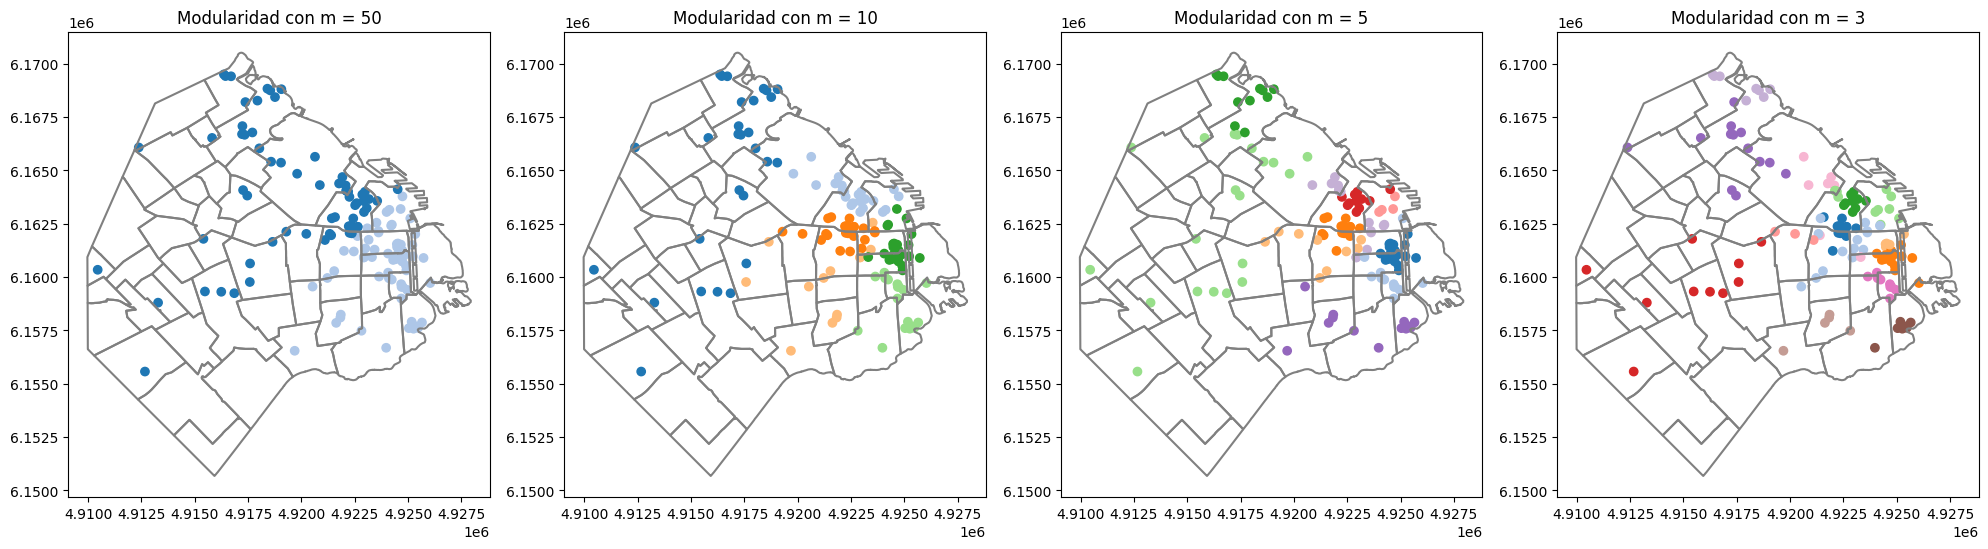

In [29]:
# graficamos los modulos.
dict_labels = crear_labels(lista_matrices_modular)
subplot_colores_puntos(lista_matrices_modular, dict_labels, [f"Modularidad con m = {m}" for m in m_list])

IndexError: list index out of range

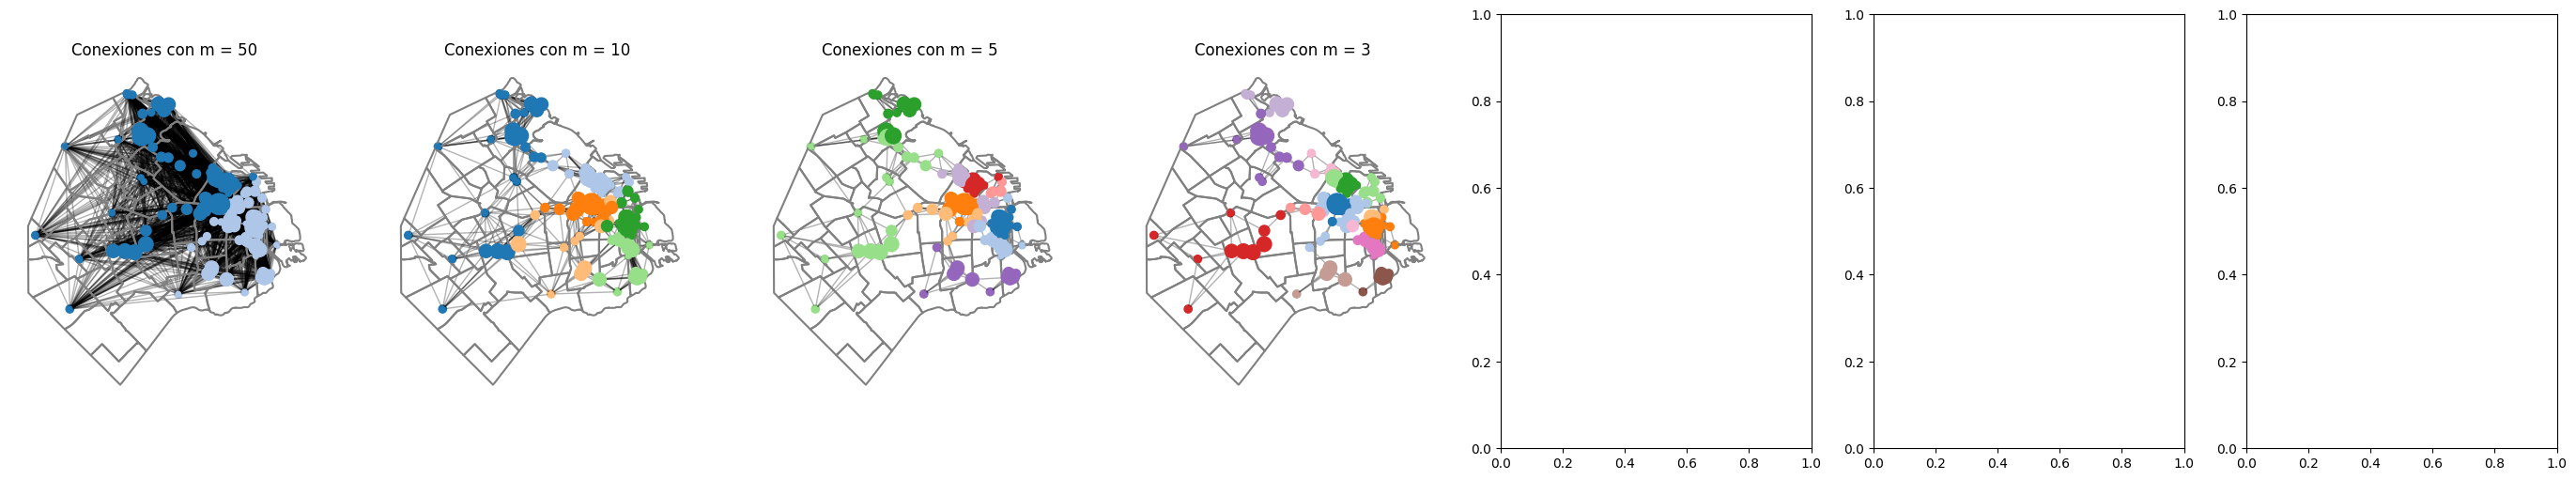

In [30]:
subplots_aristas(lista_sim, dict_labels,  [f"Conexiones con m = {m}" for m in m_list])


##### Grafico interactivo

In [ ]:

import plotly.graph_objects as go
import shapely
import networkx as nx
import numpy as np

# Función auxiliar: convertir polígonos en líneas para Plotly
def polygon_to_plotly_lines(polygon):
    if isinstance(polygon, shapely.geometry.multipolygon.MultiPolygon):
        polygons = polygon.geoms
    else:
        polygons = [polygon]

    lines = []
    for poly in polygons:
        x, y = poly.exterior.xy
        lines.append(go.Scatter(
            x=list(x), y=list(y),
            mode='lines',
            line=dict(color='lightgray', width=1),
            hoverinfo='skip',
            showlegend=False
        ))
    return lines

# Preparamos coordenadas proyectadas de nodos
museos_proj = museos.to_crs("EPSG:22184")
G_x = museos_proj.get_coordinates()['x']
G_y = museos_proj.get_coordinates()['y']

# Barrios proyectados
barrios_proj = barrios.to_crs("EPSG:22184")

# Iteramos por cada matriz en lista_sim
for i in range(len(lista_sim)):
    A = lista_sim[i]
    G = nx.from_numpy_array(A)

    # Layout basado en coordenadas geográficas
    G_layout = {j: (G_x[j], G_y[j]) for j in G.nodes}

    # Trazas de aristas
    edge_x = []
    edge_y = []
    for u, v in G.edges():
        x0, y0 = G_layout[u]
        x1, y1 = G_layout[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='gray'),
        hoverinfo='none',
        mode='lines')

    # Trazas de nodos
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G_layout[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        marker=dict(
            color=[dict_labels[i][j] for j in G.nodes],
            size=10,
            line_width=1
        ),
        text=[f"nodo {j}" for j in G.nodes],
        hoverinfo='text'
    )

    # Trazas de los polígonos de barrios
    barrio_traces = []
    for geom in barrios_proj.geometry:
        barrio_traces += polygon_to_plotly_lines(geom)

    # Creamos la figura
    fig = go.Figure(
        data=barrio_traces + [edge_trace, node_trace],
        layout=go.Layout(
            title=f"Modularidad con m = {m_list[i]}",
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False, scaleanchor="x"),
        )
    )

    # Mostramos la figura
    fig.show()



#### Laplaciano

In [ ]:
from shapely.geometry import MultiPoint

def subplot_colores_puntos_convex(lista_matrices, dict_labels, title):
    museos_proj = museos.to_crs("EPSG:22184")
    G_coords = museos_proj.get_coordinates()
    G_x = G_coords['x']
    G_y = G_coords['y']
    barrios_proj = barrios.to_crs("EPSG:22184")

    n = len(lista_matrices)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 6))

    if n == 1:
        axes = [axes]  # por si hay un solo plot

    for i, ax in enumerate(axes):
        colors = [dict_labels[i].get(j, (0.5, 0.5, 0.5, 1)) for j in range(len(G_x))]

        barrios_proj.boundary.plot(color='gray', ax=ax)
        ax.scatter(G_x, G_y, color=colors)

        # Agrupamos puntos por color y generamos envoltorios
        puntos_por_color = {}
        for j in range(len(G_x)):
            color = dict_labels[i].get(j)
            if color:
                puntos_por_color.setdefault(color, []).append((G_x.iloc[j], G_y.iloc[j]))

        for color, puntos in puntos_por_color.items():
            if len(puntos) < 3:
                continue  # no tiene sentido con menos de 3 puntos
            multipoint = MultiPoint(puntos)
            hull = multipoint.convex_hull
            if hull.geom_type == 'Polygon':
                xs, ys = hull.exterior.xy
                ax.fill(xs, ys, alpha=0.3, color=color, edgecolor='black', linewidth=1.5)

        ax.set_title(title[i] if isinstance(title, list) else title)

    plt.tight_layout()

subplot_colores_puntos_envelope(lista_matrices_modular, dict_labels, [f"Modularidad con m = {m}" for m in m_list])

In [ ]:
niveles = 2
lista_matrices_laplaciano = [laplaciano_iterativo(matriz, niveles) for matriz in lista_sim]


import itertools
for i in range(len(lista_matrices_laplaciano)):
  flattened_list = list(itertools.chain(*lista_matrices_laplaciano[i]))
  #print(set(flattened_list).difference(set([i for i in range(len(flattened_list))])))


#lista_matrices_laplaciano[3]


In [ ]:
dict_labels = crear_labels(lista_matrices_laplaciano)
subplot_colores_puntos(lista_matrices_laplaciano, dict_labels, [f"Laplaciano con m = {m}" for m in m_list])

In [ ]:
subplots_aristas(lista_sim, dict_labels,  [f"Conexiones dado m = {m} (laplaciano)" for m in m_list])

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres